In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import os
from cv2 import cv2 as cv
import random 
import argparse
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd

torch.__version__

'1.11.0+cu113'

Definition der Datensatz Klasse, diese stellt Bilder + Annotationen zum training bereit. Die Bilder werden dabei zur trainingszeit zusammen gesetzt sodass eine Explizite größen angabe erfolgen muss.

In [2]:
from datasets.dataset_fake import fake_dataset

In [3]:
class2id = {"stop": 1, "yield": 2, "yieldAhead": 3, "merge": 4, "signalAhead": 5, "pedestrianCrossing": 6, "keepRight": 7, "speedLimit35": 8, "speedLimit25":9}
# dataset definition
class myDataset(Dataset):
    # load the dataset
    def __init__(self,root,transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imgs"))))
        #with open(os.path.join(self.root, "annotations.csv")) as file:
        #    self.data = csv.reader(self.data)
        self.data = pd.read_csv(os.path.join(self.root, "annotations.csv"))
    # get a row at an index
    def __getitem__(self, idx):
        idx = idx -1
        img_path = os.path.join(self.root, "imgs", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        row = self.data.iloc[idx]
        
        boxes = []
        
        x1 = int(row[1])
        y1 = int(row[2])
        x2 = int(row[3])
        y2 = int(row[4])
        label = class2id[row[5]]#int(row[5])
        boxes.append([x1, y1, x2, y2])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor([label], dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = torch.tensor([False])
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

Testing the Dataset

In [4]:
dataset = fake_dataset("blender/out", "backgrounds", 1, (1, 3), 700, (30, 200))

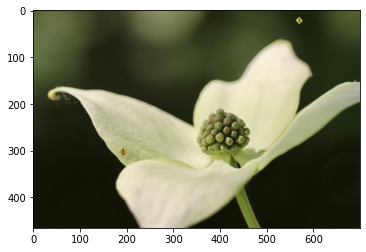

{'boxes': tensor([[185., 295., 201., 311.],
        [562.,  14., 577.,  30.]]), 'labels': tensor([5, 4]), 'image_id': tensor([0]), 'area': tensor([17424., 10201.]), 'iscrowd': tensor([False, False])}


In [5]:
img, target = dataset.__getitem__(0)
for bbox in target["boxes"]:
    cv
plt.figure()
plt.imshow(img)
plt.show()
print(target)

In [6]:
import detection.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.Normalize())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Setting up the Model, Dataset and Dataloaders

In [7]:
import detection.utils as utils
device = torch.device("cuda")
model = torchvision.models.detection.fcos_resnet50_fpn(num_classes=10)
model.to(device)
dataset_train = fake_dataset("blender/out", "backgrounds", 1000, (1, 3), 700, (30, 200), get_transform(True))
dataset_eval = myDataset('db_lisa_tiny', get_transform(False))
train_loader = DataLoader(dataset_train, 4, collate_fn=utils.collate_fn)
eval_loader = DataLoader(dataset_eval, 1, collate_fn=utils.collate_fn)


In [8]:
test_img, test_target = dataset_train.__getitem__(0)
#model([test_img], [test_target])

In [9]:

#@todo Fix Hardcoded params
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

from detection.engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, eval_loader, device=device)


Epoch: [0]  [  0/250]  eta: 0:21:20  lr: 0.000025  loss: 3.0130 (3.0130)  loss_classifier: 2.2780 (2.2780)  loss_box_reg: 0.0317 (0.0317)  loss_objectness: 0.6940 (0.6940)  loss_rpn_box_reg: 0.0093 (0.0093)  time: 5.1234  data: 0.6977  max mem: 1417
Epoch: [0]  [ 10/250]  eta: 0:04:56  lr: 0.000226  loss: 2.9560 (2.9162)  loss_classifier: 2.2332 (2.1949)  loss_box_reg: 0.0108 (0.0141)  loss_objectness: 0.6951 (0.6951)  loss_rpn_box_reg: 0.0093 (0.0121)  time: 1.2334  data: 0.5819  max mem: 1560
Epoch: [0]  [ 20/250]  eta: 0:03:53  lr: 0.000426  loss: 2.6533 (2.5251)  loss_classifier: 1.9455 (1.8071)  loss_box_reg: 0.0108 (0.0129)  loss_objectness: 0.6937 (0.6937)  loss_rpn_box_reg: 0.0098 (0.0113)  time: 0.8094  data: 0.5316  max mem: 1566
Epoch: [0]  [ 30/250]  eta: 0:03:29  lr: 0.000627  loss: 1.3244 (2.0238)  loss_classifier: 0.5896 (1.3090)  loss_box_reg: 0.0141 (0.0139)  loss_objectness: 0.6881 (0.6892)  loss_rpn_box_reg: 0.0102 (0.0116)  time: 0.8000  data: 0.5215  max mem: 1566


In [10]:
torch.save(model,"models/fcos_resnet50_fpn.pth")